In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

dataset = CIFAR10(root='data/', download=True, transform=transform_train)
test_dataset = CIFAR10(root='data/', train=False, transform=transform_test)

dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )

In [ ]:
classes = dataset.classes

class_count = {}
for _, index in dataset:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
    
class_count

{'airplane': 5000,
 'automobile': 5000,
 'bird': 5000,
 'cat': 5000,
 'deer': 5000,
 'dog': 5000,
 'frog': 5000,
 'horse': 5000,
 'ship': 5000,
 'truck': 5000}

In [ ]:
torch.manual_seed(43)
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

In [ ]:
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, pin_memory=True)

In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in val_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])
tensor([8, 2, 3, 0, 6, 3, 9, 8, 7, 8])

Validation Set:
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])
tensor([6, 4, 2, 5, 4, 9, 1, 7, 2, 1])

Testing Set:
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


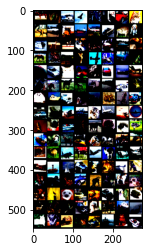

horse cat   automobile bird  frog  cat   automobile cat   deer  automobile truck ship  airplane automobile bird  dog   deer  horse horse automobile frog  automobile automobile dog   horse frog  horse bird  airplane airplane truck frog  ship  automobile cat   automobile frog  automobile ship  airplane bird  horse horse horse truck ship  airplane cat   dog   ship  truck horse ship  frog  cat   truck automobile frog  truck automobile cat   airplane airplane airplane bird  dog   ship  bird  horse frog  cat   bird  ship  bird  horse automobile horse horse truck bird  deer  deer  airplane horse airplane cat   automobile ship  truck ship  ship  automobile dog   frog  airplane dog   dog   truck frog  automobile cat   cat   dog   dog   cat   bird  dog   automobile deer  automobile dog   frog  deer  bird  bird  automobile dog   horse ship  deer  cat   cat   truck frog  automobile ship  cat   ship 


In [ ]:
def imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
!pip install brevitas
from torch.nn import Module
import torch.nn as nn
import torch.nn.functional as F
import brevitas.nn as qnn

from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU, QuantIdentity
from brevitas.quant import SignedBinaryWeightPerTensorConst

from brevitas.core.quant import BinaryQuant
from brevitas.core.scaling import ParameterScaling, ConstScaling
from brevitas.inject import ExtendedInjector
from brevitas.proxy import WeightQuantProxyFromInjector, ActQuantProxyFromInjector

class MyBinaryQuantizer(ExtendedInjector):
    tensor_quant = BinaryQuant
    scaling_impl=ConstScaling
    scaling_init=1.000000

class MyBinaryWeightQuantizer(MyBinaryQuantizer):
    proxy_class = WeightQuantProxyFromInjector

class MySignedBinaryActQuantizer(MyBinaryQuantizer):
    proxy_class = ActQuantProxyFromInjector
    signed = True

class binAlexNet(nn.Module):

    def __init__(self, num_classes=10):
        super(binAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            QuantReLU(inplace=True, act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True),
            
            QuantConv2d(64, 192, kernel_size=3, padding=1, weight_quant=MyBinaryWeightQuantizer, bias=False),
            nn.MaxPool2d(kernel_size=2),
            QuantReLU(inplace=True, act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True),
            
            QuantConv2d(192, 384, kernel_size=3, padding=1, weight_quant=MyBinaryWeightQuantizer, bias=False),
            QuantReLU(inplace=True, act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True),
            
            QuantConv2d(384, 256, kernel_size=3, padding=1, weight_quant=MyBinaryWeightQuantizer, bias=False),
            QuantReLU(inplace=True, act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True),
            
            QuantConv2d(256, 256, kernel_size=3, padding=1, weight_quant=MyBinaryWeightQuantizer, bias=False),
            nn.MaxPool2d(kernel_size=2),
            QuantReLU(inplace=True, act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True),
            )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            QuantLinear(256 * 6 * 6, 4096, weight_quant=MyBinaryWeightQuantizer, bias=False),
            QuantReLU(act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True),
            nn.Dropout(0.5),
            QuantLinear(4096, 4096, weight_quant=MyBinaryWeightQuantizer, bias=False),
            QuantReLU(act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True),
            QuantLinear(4096, 10, bias=True)
        )
        

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)

        return logits

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 403 kB 5.1 MB/s 


In [ ]:

class bBaseBlock(nn.Module):
    alpha = 1

    def __init__(self, input_channel, output_channel, t = 6, downsample = False):
        """
            t:  expansion factor, t*input_channel is channel of expansion layer
            alpha:  width multiplier, to get thinner models
            rho:    resolution multiplier, to get reduced representation
        """ 
        super(bBaseBlock, self).__init__()
        self.stride = 2 if downsample else 1
        self.downsample = downsample
        self.shortcut = (not downsample) and (input_channel == output_channel) 

        # apply alpha
        input_channel = int(self.alpha * input_channel)
        output_channel = int(self.alpha * output_channel)
        
        # for main path:
        c  = t * input_channel
        # 1x1   point wise conv
        self.conv1 = QuantConv2d(input_channel, c, kernel_size = 1, weight_quant=MyBinaryWeightQuantizer, bias=False)
        self.bn1 = nn.BatchNorm2d(c)
        # 3x3   depth wise conv
        self.conv2 = QuantConv2d(c, c, kernel_size = 3, stride = self.stride, padding = 1, groups = c, weight_quant=MyBinaryWeightQuantizer, bias=False)
        self.bn2 = nn.BatchNorm2d(c)
        # 1x1   point wise conv
        self.conv3 = QuantConv2d(c, output_channel, kernel_size = 1, weight_quant=MyBinaryWeightQuantizer, bias=False)
        self.bn3 = nn.BatchNorm2d(output_channel)
        

    def forward(self, inputs):
        # main path
        x = F.relu6(self.bn1(self.conv1(inputs)), inplace = True)
        x = F.relu6(self.bn2(self.conv2(x)), inplace = True)
        x = self.bn3(self.conv3(x))

        # shortcut path
        x = x + inputs if self.shortcut else x

        return x

class binMobileNetV2(nn.Module):
    def __init__(self, output_size, alpha = 1):
        super(binMobileNetV2, self).__init__()
        self.output_size = output_size

        # first conv layer (dont quantise)
        self.conv0 = nn.Conv2d(3, int(32*alpha), kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn0 = nn.BatchNorm2d(int(32*alpha))

        # build bottlenecks
        BaseBlock.alpha = alpha
        self.bottlenecks = nn.Sequential(
            BaseBlock(32, 16, t = 1, downsample = False),
            BaseBlock(16, 24, downsample = False),
            BaseBlock(24, 24),
            BaseBlock(24, 32, downsample = False),
            BaseBlock(32, 32),
            BaseBlock(32, 32),
            BaseBlock(32, 64, downsample = True),
            BaseBlock(64, 64),
            BaseBlock(64, 64),
            BaseBlock(64, 64),
            BaseBlock(64, 96, downsample = False),
            BaseBlock(96, 96),
            BaseBlock(96, 96),
            BaseBlock(96, 160, downsample = True),
            BaseBlock(160, 160),
            BaseBlock(160, 160),
            BaseBlock(160, 320, downsample = False))

        # last conv layers and fc layer
        self.conv1 = QuantConv2d(int(320*alpha), 1280, kernel_size = 1, weight_quant=MyBinaryWeightQuantizer, bias=False)
        self.bn1 = nn.BatchNorm2d(1280)
        self.fc = QuantLinear(1280, output_size, weight_quant=MyBinaryWeightQuantizer, bias=False)

        # weights init
        self.weights_init()


    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def forward(self, inputs):

        # first conv layer
        x = F.relu6(self.bn0(self.conv0(inputs)), inplace = True)
        # assert x.shape[1:] == torch.Size([32, 32, 32])

        # bottlenecks
        x = self.bottlenecks(x)
        # assert x.shape[1:] == torch.Size([320, 8, 8])

        # last conv layer
        x = F.relu6(self.bn1(self.conv1(x)), inplace = True)
        # assert x.shape[1:] == torch.Size([1280,8,8])

        # global pooling and fc (in place of conv 1x1 in paper)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        return x

In [ ]:
class bBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(bBasicBlock, self).__init__()
        self.conv1 = QuantConv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, weight_quant=MyBinaryWeightQuantizer, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = QuantConv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, weight_quant=MyBinaryWeightQuantizer, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                QuantConv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, weight_quant=MyBinaryWeightQuantizer, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class bBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(bBottleneck, self).__init__()
        self.conv1 = QuantConv2d(in_planes, planes, kernel_size=1, weight_quant=MyBinaryWeightQuantizer, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = QuantConv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, weight_quant=MyBinaryWeightQuantizer, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = QuantConv2d(planes, self.expansion *
                               planes, kernel_size=1, weight_quant=MyBinaryWeightQuantizer, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                QuantConv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, weight_quant=MyBinaryWeightQuantizer, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class bResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(bResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = QuantLinear(512*block.expansion, num_classes, weight_quant=MyBinaryWeightQuantizer, bias=False)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def binResNet18():
    return bResNet(bBasicBlock, [2, 2, 2, 2])

In [ ]:
class binVGG(Module):
    def __init__(self):
        super(binVGG, self).__init__()
        self.conv1 = QuantConv2d(in_channels= 3,
                                     out_channels= 64,
                                     kernel_size= 3,
                                     padding= 1)
        self.relu1 = QuantReLU(act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = QuantConv2d(in_channels= 64,
                                     out_channels= 128,
                                     kernel_size= 3,
                                     padding= 1, weight_quant=MyBinaryWeightQuantizer, bias=False)

        self.relu2 = QuantReLU(act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True)

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
       
        self.conv3 = QuantConv2d(in_channels= 128,
                                     out_channels= 256,
                                     kernel_size= 3,
                                     padding= 1, weight_quant=MyBinaryWeightQuantizer, bias=False )

        self.relu3 = QuantReLU(act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True)
        self.conv4 = QuantConv2d(in_channels= 256,
                                     out_channels= 256,
                                     kernel_size= 3,
                                     padding= 1, weight_quant=MyBinaryWeightQuantizer, bias=False)

        self.relu4 = QuantReLU(act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = QuantConv2d(in_channels= 256,
                                     out_channels= 512,
                                     kernel_size= 3,
                                     padding= 1, weight_quant=MyBinaryWeightQuantizer, bias=False )

        self.relu5 = QuantReLU(act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True)
        
        self.conv6 = qnn.QuantConv2d(in_channels= 512,
                                     out_channels= 512,
                                     kernel_size= 3,
                                     padding= 1, weight_quant=MyBinaryWeightQuantizer, bias=False)

        self.relu6 = QuantReLU(act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = qnn.QuantConv2d(in_channels= 512,
                                     out_channels= 512,
                                     kernel_size= 3,
                                     padding= 1, weight_quant=MyBinaryWeightQuantizer, bias=False )

        self.relu7 = QuantReLU(act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True)
        
        self.conv8 = qnn.QuantConv2d(in_channels= 512,
                                     out_channels= 512,
                                     kernel_size= 3,
                                     padding= 1, weight_quant=MyBinaryWeightQuantizer, bias=False)

        self.relu8 = QuantReLU(act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True)

        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        """
        full precision layers
        self.fc1   = nn.Linear(4*4*256, 1024)
        self.relufc1 = nn.ReLU()
        self.fc2   = nn.Linear(1024,512)
        self.relufc2 = nn.ReLU()
        self.fc2   = nn.Linear(512, 10)
        """
        self.classifier = nn.Sequential(
            nn.Dropout(),
            qnn.QuantLinear(512, 512, weight_quant=MyBinaryWeightQuantizer, bias=False),
            QuantReLU(act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True),
            nn.Dropout(),
            qnn.QuantLinear(512, 512, weight_quant=MyBinaryWeightQuantizer, bias=False),
            QuantReLU(act_quant=MySignedBinaryActQuantizer, return_quant_tensor=True),
            qnn.QuantLinear(512, 10, weight_quant=MyBinaryWeightQuantizer, bias=False),
        )
        

    def forward(self, x):
        out = self.relu1(self.conv1(x))
        out = self.pool1(out)
        out = self.relu2(self.conv2(out))
        out = self.pool2(out)
        
        out = self.relu3(self.conv3(out))
        out = self.relu4(self.conv4(out))
        out = self.pool3(out)
        
        out = self.relu5(self.conv5(out))
        out = self.relu6(self.conv6(out))
        out = self.pool4(out)
        out = self.relu7(self.conv7(out))
        out = self.relu8(self.conv8(out))
        out = self.pool5(out)

        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        
        return out

In [ ]:
# select model
model = binAlexNet()

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 56,825,546 trainable parameters


In [ ]:
from itertools import product

def compute_accuracy(model, data_loader, device):
    model.eval()
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)
            if isinstance(logits, torch.distributed.rpc.api.RRef):
                logits = logits.local_value()
            _, predicted_labels = torch.max(logits, 1)
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            if isinstance(logits, torch.distributed.rpc.api.RRef):
                logits = logits.local_value()
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss


def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)
    return mat

In [ ]:
import time
import tensorflow as tf

def train_classifier(num_epochs, model, optimizer, device, 
                               train_loader, valid_loader=None, 
                               loss_fn=None, logging_interval=100, 
                               skip_epoch_stats=False):
    
    log_dict = {'train_loss_per_batch': [],
                'train_acc_per_epoch': [],
                'train_loss_per_epoch': [],
                'valid_acc_per_epoch': [],
                'valid_loss_per_epoch': []}
    
    if loss_fn is None:
        loss_fn = F.cross_entropy

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # FORWARD AND BACK PROP
            logits = model(features)
            if isinstance(logits, torch.distributed.rpc.api.RRef):
                logits = logits.local_value()
            loss = loss_fn(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_loss_per_batch'].append(loss.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()

            with torch.set_grad_enabled(False):  # save memory during inference

                train_acc = compute_accuracy(model, train_loader, device)
                train_loss = compute_epoch_loss(model, train_loader, device)
                print('***Epoch: %03d/%03d | Train. Acc.: %.3f%% | Loss: %.3f' % (
                      epoch+1, num_epochs, train_acc, train_loss))
                log_dict['train_loss_per_epoch'].append(train_loss.item())
                log_dict['train_acc_per_epoch'].append(train_acc.item())
                # writer.add_scalar("train loss", train_loss.item(), batch_idx)
                # writer.add_scalar("train accuracy", train_acc.item(), batch_idx)

                with train_summary_writer.as_default():
                    tf.summary.scalar('train loss', train_loss.item(), step=epoch)
                    tf.summary.scalar('train accuracy', train_acc.item(), step=epoch)

                if valid_loader is not None:
                    valid_acc = compute_accuracy(model, valid_loader, device)
                    valid_loss = compute_epoch_loss(model, valid_loader, device)
                    print('***Epoch: %03d/%03d | Valid. Acc.: %.3f%% | Loss: %.3f' % (
                          epoch+1, num_epochs, valid_acc, valid_loss))
                    log_dict['valid_loss_per_epoch'].append(valid_loss.item())
                    log_dict['valid_acc_per_epoch'].append(valid_acc.item())
                    # writer.add_scalar("val loss", valid_loss.item(), batch_idx)
                    # writer.add_scalar("val accuracy", valid_acc.item(), batch_idx)

                    with train_summary_writer.as_default():
                        tf.summary.scalar('validation loss', valid_loss.item(), step=epoch)
                        tf.summary.scalar('validation accuracy', valid_acc.item(), step=epoch)

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    return log_dict

In [ ]:
# wandb.watch(model, log='all')
log_dict = train_classifier(num_epochs=30, model=model, 
                                      optimizer=optimizer, device=device, 
                                      train_loader=train_loader, valid_loader=val_loader, 
                                      logging_interval=100)

Epoch: 001/030 | Batch 0000/0313 | Loss: 2.3019
Epoch: 001/030 | Batch 0100/0313 | Loss: 1.7844
Epoch: 001/030 | Batch 0200/0313 | Loss: 1.7808
Epoch: 001/030 | Batch 0300/0313 | Loss: 1.6196
***Epoch: 001/030 | Train. Acc.: 36.940% | Loss: 1.616
***Epoch: 001/030 | Valid. Acc.: 36.380% | Loss: 1.636
Time elapsed: 1.38 min
Epoch: 002/030 | Batch 0000/0313 | Loss: 1.6295
Epoch: 002/030 | Batch 0100/0313 | Loss: 1.6443
Epoch: 002/030 | Batch 0200/0313 | Loss: 1.7790
Epoch: 002/030 | Batch 0300/0313 | Loss: 1.4385
***Epoch: 002/030 | Train. Acc.: 48.567% | Loss: 1.393
***Epoch: 002/030 | Valid. Acc.: 47.980% | Loss: 1.418
Time elapsed: 2.65 min
Epoch: 003/030 | Batch 0000/0313 | Loss: 1.3792
Epoch: 003/030 | Batch 0100/0313 | Loss: 1.4073
Epoch: 003/030 | Batch 0200/0313 | Loss: 1.3363
Epoch: 003/030 | Batch 0300/0313 | Loss: 1.2219
***Epoch: 003/030 | Train. Acc.: 54.167% | Loss: 1.266
***Epoch: 003/030 | Valid. Acc.: 52.990% | Loss: 1.309
Time elapsed: 3.90 min
Epoch: 004/030 | Batch 00

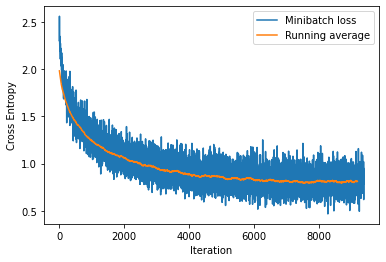

In [ ]:
loss_list = log_dict['train_loss_per_batch']

plt.plot(loss_list, label='Minibatch loss')
plt.plot(np.convolve(loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

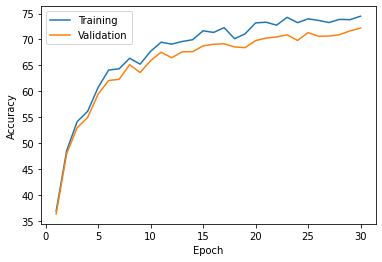

In [ ]:
plt.plot(np.arange(1, 30+1), log_dict['train_acc_per_epoch'], label='Training')
plt.plot(np.arange(1, 30+1), log_dict['valid_acc_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=train_loader,
                                 device=device)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=device)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=val_loader,
                                 device=device)
    

print(f'Train ACC: {valid_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')